<a href="https://colab.research.google.com/github/PanchamSharma2511/24mcs102_exp3_pancham_sharma/blob/main/24mcs102_exp4_pancham_sharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

In [2]:
import wandb

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 24mcs102 (24mcs102-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
wandb.finish()

In [5]:
import wandb
import random

# Define a simple training function
def train_dummy_model(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Simulate training for 5 epochs
        for epoch in range(5):
            loss = random.uniform(0.1, 1.0)  # Generate random loss
            wandb.log({"loss": loss})  # Log loss to WandB

            print(f"Epoch {epoch+1}: Loss = {loss:.4f}")

# Define the sweep configuration
sweep_config = {
    "method": "random",
    "metric": {"name": "loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"values": [0.01, 0.001]},
        "batch_size": {"values": [16, 32]}
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="wandb-sweep-test")

# Run the agent
wandb.agent(sweep_id, function=train_dummy_model, count=3)

Create sweep with ID: 2edgbqdg
Sweep URL: https://wandb.ai/24mcs102-national-institute-of-technology-hamirpur/wandb-sweep-test/sweeps/2edgbqdg


wandb: Agent Starting Run: qq7pi8vw with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.01


Epoch 1: Loss = 0.9008
Epoch 2: Loss = 0.9596
Epoch 3: Loss = 0.9902
Epoch 4: Loss = 0.4153
Epoch 5: Loss = 0.9313


loss,▇██▁▇
loss,0.93131


wandb: Agent Starting Run: mp6srucb with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.01


Epoch 1: Loss = 0.5177
Epoch 2: Loss = 0.2360
Epoch 3: Loss = 0.6446
Epoch 4: Loss = 0.4817
Epoch 5: Loss = 0.9331


loss,▄▁▅▃█
loss,0.93313


wandb: Agent Starting Run: q8ykrirf with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001


Epoch 1: Loss = 0.7751
Epoch 2: Loss = 0.9844
Epoch 3: Loss = 0.2116
Epoch 4: Loss = 0.1591
Epoch 5: Loss = 0.5550


loss,▆█▁▁▄
loss,0.555


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Define a flexible neural network
class FashionMNISTModel(nn.Module):
    def __init__(self, input_size, hidden_layers, layer_size, output_size, activation, weight_init):
        super(FashionMNISTModel, self).__init__()
        layers = []
        prev_size = input_size

        for _ in range(hidden_layers):
            layer = nn.Linear(prev_size, layer_size)
            if weight_init == 'Xavier':
                nn.init.xavier_uniform_(layer.weight)
            layers.append(layer)
            layers.append(activation())
            prev_size = layer_size

        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Training function
def train_network(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Load dataset
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
        X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

        # Select only 20 random samples
        random_indices = np.random.choice(len(X_train), 20, replace=False)
        X_train, y_train = X_train[random_indices], y_train[random_indices]

        # Split into train and validation sets (90% train, 10% validation)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        # Convert to PyTorch tensors
        tensor_x_train = torch.tensor(X_train, dtype=torch.float32)
        tensor_y_train = torch.tensor(y_train, dtype=torch.long)
        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train),
                                                   batch_size=config.batch_size, shuffle=True)

        tensor_x_val = torch.tensor(X_val, dtype=torch.float32)
        tensor_y_val = torch.tensor(y_val, dtype=torch.long)
        val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tensor_x_val, tensor_y_val),
                                                 batch_size=config.batch_size, shuffle=False)

        # Initialize model
        activation_fn = {'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh, 'ReLU': nn.ReLU}[config.activation]
        model = FashionMNISTModel(X_train.shape[1], config.hidden_layers, config.layer_size, 10,
                                  activation=activation_fn, weight_init=config.weight_init)

        # Define optimizer
        optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(config.epochs):
            model.train()
            epoch_loss = 0
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_train_loss = epoch_loss / len(train_loader)
            wandb.log({"Training Loss": avg_train_loss})

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            wandb.log({"Validation Loss": avg_val_loss})

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Training Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")

# Define WandB Sweep Configuration
sweep_config = {
    "method": "bayes",  # Bayesian optimization for efficient search
    "metric": {"name": "Validation Loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [5]},  # Reduced epochs for quicker experiments
        "hidden_layers": {"values": [2]},  # Reduced hidden layers for faster computation
        "layer_size": {"values": [32]},  # Reduced layer size for faster computation
        "weight_decay": {"values": [0.0005]},
        "learning_rate": {"values": [1e-3]},
        "optimizer": {"values": ["SGD"]},
        "batch_size": {"values": [16]},  # Reduced batch size for faster training
        "weight_init": {"values": ["Xavier"]},
        "activation": {"values": ["ReLU"]}
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-sweep")

# Run the sweep agent
wandb.agent(sweep_id, function=train_network, count=5)

Create sweep with ID: qg686r1n
Sweep URL: https://wandb.ai/24mcs102-national-institute-of-technology-hamirpur/fashion-mnist-sweep/sweeps/qg686r1n


wandb: Agent Starting Run: gcjrmzxo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 0: Training Loss = 2.3637, Validation Loss = 2.3524


Training Loss,█▅▁▃▅
Validation Loss,█▅▅▆▁
Training Loss,2.32717
Validation Loss,2.34672


wandb: Agent Starting Run: ryyc61pq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.2320, Validation Loss = 2.4770


Training Loss,▁█▅█▆
Validation Loss,▇█▁▂▃
Training Loss,2.40482
Validation Loss,2.47145


wandb: Agent Starting Run: krynf9de with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.3449, Validation Loss = 2.1471


Training Loss,█▂▇▅▁
Validation Loss,█▆▅▃▁
Training Loss,2.19424
Validation Loss,2.13255


wandb: Agent Starting Run: b2x7524p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.2381, Validation Loss = 2.4318


Training Loss,▁▇█▄█
Validation Loss,▆█▄▃▁
Training Loss,2.35538
Validation Loss,2.42892


wandb: Agent Starting Run: u5xkbj8u with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.2050, Validation Loss = 2.1501


Training Loss,▁▆█▇▆
Validation Loss,▁▃▅▆█
Training Loss,2.3234
Validation Loss,2.15688


Create sweep with ID: 3yi5q9je
Sweep URL: https://wandb.ai/24mcs102-national-institute-of-technology-hamirpur/Ex-4-fashion-mnist-sweep/sweeps/3yi5q9je


wandb: Agent Starting Run: xpebsmpb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.2482, Validation Loss = 2.4891


Training Loss,▁▃▇█▄
Validation Loss,▇█▇▃▁
Final Training Loss,2.30562
Final Validation Loss,2.48339
Training Loss,2.30562
Validation Loss,2.48339


wandb: Agent Starting Run: 3s7gpi7o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.3858, Validation Loss = 2.3102


Training Loss,█▁▂▆▂
Validation Loss,▁▂▅▆█
Final Training Loss,2.2167
Final Validation Loss,2.31275
Training Loss,2.2167
Validation Loss,2.31275


wandb: Agent Starting Run: s7zhu8zk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.3735, Validation Loss = 2.1003


Training Loss,█▁▁▁▄
Validation Loss,▁▅▅▅█
Final Training Loss,2.32088
Final Validation Loss,2.10441
Training Loss,2.32088
Validation Loss,2.10441


wandb: Agent Starting Run: 6fwcmutl with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.1693, Validation Loss = 2.0524


Training Loss,▁██▆▄
Validation Loss,▁▅██▂
Final Training Loss,2.27176
Final Validation Loss,2.05259
Training Loss,2.27176
Validation Loss,2.05259


wandb: Agent Starting Run: r8q67cwb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 2
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: Xavier


Epoch 0: Training Loss = 2.1548, Validation Loss = 2.0702


Training Loss,▁█▅▅▇
Validation Loss,▆█▆▄▁
Final Training Loss,2.3013
Final Validation Loss,2.06447
Training Loss,2.3013
Validation Loss,2.06447


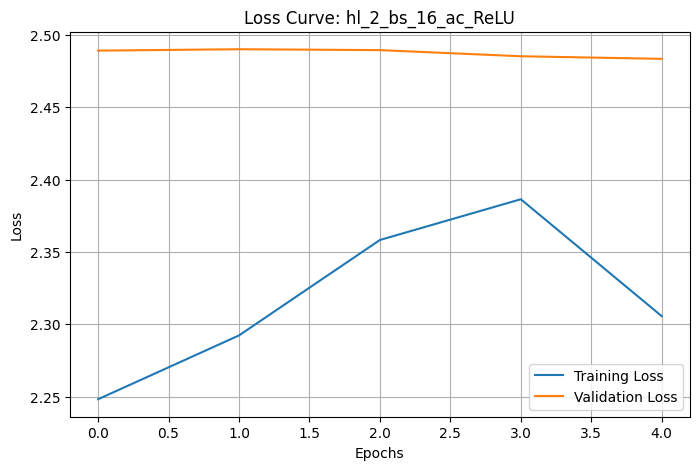

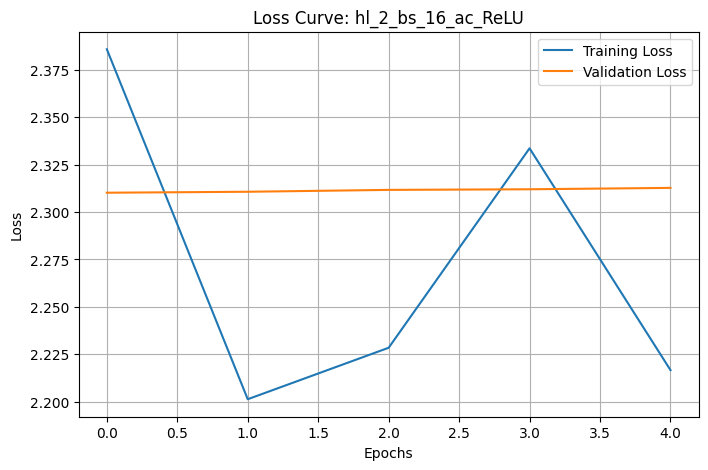

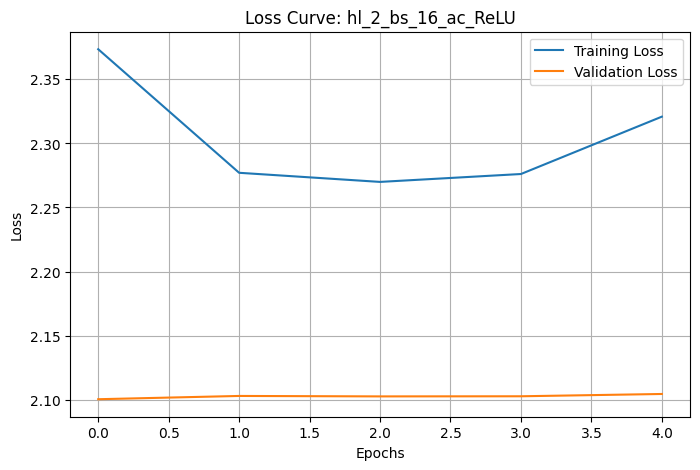

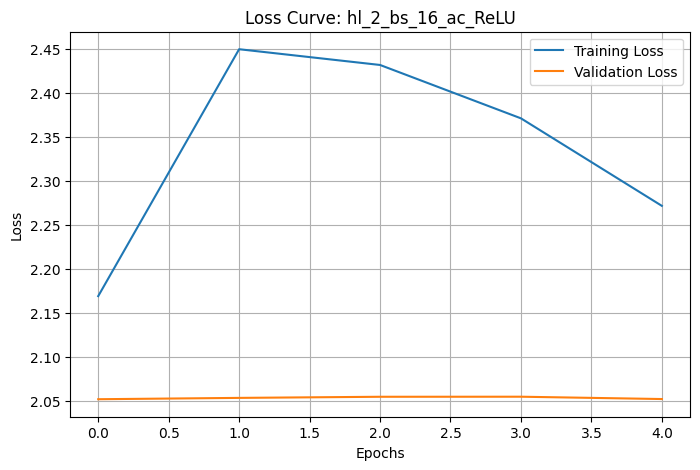

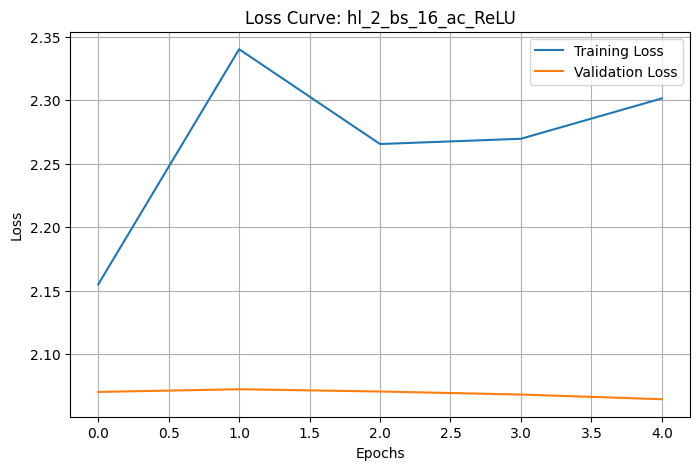

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Define a flexible neural network
class FashionMNISTModel(nn.Module):
    def __init__(self, input_size, hidden_layers, layer_size, output_size, activation, weight_init):
        super(FashionMNISTModel, self).__init__()
        layers = []
        prev_size = input_size

        for _ in range(hidden_layers):
            layer = nn.Linear(prev_size, layer_size)
            if weight_init == 'Xavier':
                nn.init.xavier_uniform_(layer.weight)
            layers.append(layer)
            layers.append(activation())
            prev_size = layer_size

        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Training function
def train_network(config=None):
    with wandb.init(config=config):
        config = wandb.config

        # Give meaningful run names (e.g., hl_3_bs_16_ac_tanh)
        run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        # Load dataset
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
        X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

        # Select only 20 random samples
        random_indices = np.random.choice(len(X_train), 20, replace=False)
        X_train, y_train = X_train[random_indices], y_train[random_indices]

        # Split into train and validation sets (90% train, 10% validation)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        # Convert to PyTorch tensors
        tensor_x_train = torch.tensor(X_train, dtype=torch.float32)
        tensor_y_train = torch.tensor(y_train, dtype=torch.long)
        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tensor_x_train, tensor_y_train),
                                                   batch_size=config.batch_size, shuffle=True)

        tensor_x_val = torch.tensor(X_val, dtype=torch.float32)
        tensor_y_val = torch.tensor(y_val, dtype=torch.long)
        val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tensor_x_val, tensor_y_val),
                                                 batch_size=config.batch_size, shuffle=False)

        # Initialize model
        activation_fn = {'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh, 'ReLU': nn.ReLU}[config.activation]
        model = FashionMNISTModel(X_train.shape[1], config.hidden_layers, config.layer_size, 10,
                                  activation=activation_fn, weight_init=config.weight_init)

        # Define optimizer
        optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Tracking loss for visualization
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(config.epochs):
            model.train()
            epoch_loss = 0
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            wandb.log({"Training Loss": avg_train_loss})

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data)
                    loss = criterion(output, target)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            wandb.log({"Validation Loss": avg_val_loss})

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Training Loss = {avg_train_loss:.4f}, Validation Loss = {avg_val_loss:.4f}")

        # Generate and log plots
        plt.figure(figsize=(8, 5))
        plt.plot(range(config.epochs), train_losses, label="Training Loss")
        plt.plot(range(config.epochs), val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Loss Curve: {run_name}")
        plt.legend()
        plt.grid()

        # Save and log plot to WandB
        plt.savefig(f"{run_name}.png")
        wandb.log({f"Loss Curve ({run_name})": wandb.Image(f"{run_name}.png")})

        # Summary
        wandb.summary["Final Training Loss"] = train_losses[-1]
        wandb.summary["Final Validation Loss"] = val_losses[-1]

# Define WandB Sweep Configuration
sweep_config = {
    "method": "bayes",  # Bayesian optimization for efficient search
    "metric": {"name": "Validation Loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [5]},  # Reduced epochs for quicker experiments
        "hidden_layers": {"values": [2]},  # Reduced hidden layers for faster computation
        "layer_size": {"values": [32]},  # Reduced layer size for faster computation
        "weight_decay": {"values": [0.0005]},
        "learning_rate": {"values": [1e-3]},
        "optimizer": {"values": ["SGD"]},
        "batch_size": {"values": [16]},  # Reduced batch size for faster training
        "weight_init": {"values": ["Xavier"]},
        "activation": {"values": ["ReLU"]}
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="Ex-4-fashion-mnist-sweep")

# Run the sweep agent
wandb.agent(sweep_id, function=train_network, count=5)
